In [44]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline

bEdges = np.load('BandEdge.npy').item()
DefTot = np.load('DefectTotalEnergy.npy').item()
E0 = DefTot['default'][0]['0']
FreyCorr = np.load('FreysoldtCorrections.npy').item()
ChemPot = np.load('ChemicalReferences.npy').item()
SurfaceCalc = np.load('SurfCalc.npy').item()
text_def = np.load('LineLabels.npy').item()
colors = np.load('LineColors.npy').item()


def setChemPot(cond, delta={}):
    mu = {}
    mu['Zn'] = cond[0] + ChemPot['Zn'][0]/ChemPot['Zn'][1]['Zn']
    mu['Ge'] = cond[1] + ChemPot['Ge'][0]/ChemPot['Ge'][1]['Ge']
    mu['N'] = cond[2] + ChemPot['N'][0]/ChemPot['N'][1]['N']
    for ref in ChemPot:
        if len(ChemPot[ref][1]) == 1:
            for ele in ChemPot[ref][1]:
                if not ele in ['Zn', 'Ge', 'N']:
                    if not ele in mu: 
                        mu[ele] = 0
                    mu[ele] = min(mu[ele], ChemPot[ref][0] / ChemPot[ref][1][ele])
        elif len(ChemPot[ref][1]) == 2:
            for ele in ChemPot[ref][1]:
                if not ele in ['Zn', 'Ge', 'N']:
                    if not ele in mu: 
                        mu[ele] = 0
                    mu[ele] = min(mu[ele], ChemPot[ref][0] / ChemPot[ref][1][ele] - sum(mu[key] * ChemPot[ref][1][key] / ChemPot[ref][1][ele] for key in ChemPot[ref][1] if key != ele))
    return mu

def getPOSCARdiff(defect):
    default = {'Zn':32, 'Ge':32, 'N':64}
    n_mu = {}
    for i in DefTot[defect][1]:
        if i in default:
            n_mu[i] = DefTot[defect][1][i] - default[i]
        else: 
            n_mu[i] = DefTot[defect][1][i]
    return n_mu

def getLine(defect, cond, BandEdges = bEdges, Ef = np.arange(0, bEdges['ZnGeN2_CB']-bEdges['ZnGeN2_VB'],0.0001), charge = ''):
    chem = setChemPot(cond)
    defLoc = deepcopy(DefTot)
    defPar = defLoc[defect]
    n_mu = getPOSCARdiff(defect)
    levels = defPar[0]
    pLevels = {}
    #print levels
    #def_i_l = []
    
    if charge:
        if charge in FreyCorr[defect]:
            pass
    for i in levels:
        # add functionality to get defect levels: 
        # if str(int(i)-1) in levels:
        #    def_i_l += defPar[0][i] - defPar[0][str(int(i)-1)] - bEdges['ZnGeN2_VB']
            
        if i in FreyCorr[defect]:
            levels[i] += FreyCorr[defect][i]
        pLevels[i] = defPar[0][i] - E0 - sum(n_mu[j] * chem[j] for j in n_mu) + int(i) * (Ef + BandEdges['ZnGeN2_VB'])
    
    charges = [int(l) for l in pLevels]
    charges.sort()
    intlevels = {defect+' '+str(q)+'/'+str(q+1):round(pLevels[str(q)][0] - pLevels[str(q+1)][0],3) for q in charges[-len(charges):-1]}
    
    pDefect = np.minimum.reduce([pLevels[i] for i in pLevels])
    #print def_i_l
    return pDefect

from fractions import gcd
def FormEnth(Material):
    mat = ChemPot[Material]
    return (mat[0] - sum(ChemPot[ele][0]/ChemPot[ele][1][ele]* mat[1][ele] for ele in mat[1]))/reduce(gcd,[i for i in mat[1].values()])

def PlotForm(Defects, Condition, BandEdges=bEdges,ylimits=[]):
    fig = plt.figure()
    ax = plt.subplot(111)
    Ef = np.arange(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'],0.0001)
    textx = 0.5
    for i in Defects:
        if not i in colors:
            colour = 'black'
        else:
            colour = colors[i]
        y = getLine(i, Condition, BandEdges, Ef)
        plt.plot(Ef, y, label=i, color=colour)
        if Defects[i]:
            ax.text(Defects[i][0],Defects[i][1],text_def[i],fontdict={'size':18},color=colour)
        elif i in text_def:
            ax.text(textx,y[int(textx/max(Ef)*len(Ef))]-0.8,text_def[i],fontdict={'size':18},color=colour)
            textx += 0.4
    plt.xlim(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'])
    if ylimits:
        plt.ylim(ylimits[0],ylimits[1])
    plt.ylabel('Formation Energy (eV)', fontsize=16)
    ax.set_yticklabels(ax.get_yticks(), fontsize=16)
    plt.xlabel('Fermi Energy (eV)', fontsize=16)
    ax.set_xticklabels(ax.get_xticks(), fontsize=16)
    
def PlotForm2(Defects1, Condition1, Defects2, Condition2, BandEdges=bEdges,ylimits=[]):
    fig = plt.figure(figsize=(6,4)) 
    ax = plt.subplot(121)
    Ef = np.arange(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'],0.0001)
    textx = 0.5
    for i in Defects1:
        if not i in colors:
            colour = 'black'
        else:
            colour = colors[i]
        y = getLine(i, Condition1, BandEdges, Ef)
        plt.plot(Ef, y, label=i, color=colour)
        if Defects1[i]:
            ax.text(Defects1[i][0],Defects1[i][1],text_def[i],fontdict={'size':18},color=colour)
        elif i in text_def:
            ax.text(textx,y[int(textx/max(Ef)*len(Ef))]-0.8,text_def[i],fontdict={'size':18},color=colour)
            textx += 0.4
    plt.xlim(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'])
    if ylimits:
        plt.ylim(ylimits[0],ylimits[1])
    plt.ylabel('Formation Energy (eV)', fontsize=16)
    ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=16)
    plt.xlabel('Fermi Energy (eV)', fontsize=16)
    ax.set_xticklabels(ax.get_xticks(), fontsize=16)
    plt.title('Cu', fontsize=16)

    
    ax = plt.subplot(122)
    Ef = np.arange(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'],0.0001)
    textx = 0.5
    for i in Defects2:
        if not i in colors:
            colour = 'black'
        else:
            colour = colors[i]
        y = getLine(i, Condition2, BandEdges, Ef)
        plt.plot(Ef, y, label=i, color=colour)
        if Defects2[i]:
            ax.text(Defects2[i][0],Defects2[i][1],text_def[i],fontdict={'size':18},color=colour)
        elif i in text_def:
            ax.text(textx,y[int(textx/max(Ef)*len(Ef))]-0.8,text_def[i],fontdict={'size':18},color=colour)
            textx += 0.4
    plt.xlim(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'])
    if ylimits:
        plt.ylim(ylimits[0],ylimits[1])
    ax.set_yticklabels([], fontsize=16)
    plt.xlabel('Fermi Energy (eV)', fontsize=16)
    ax.set_xticklabels(ax.get_xticks(), fontsize=16)
    plt.title('Li', fontsize=16)

Znpoor1 = [FormEnth('ZnGeN2') - FormEnth('Ge3N4')/2, 0, FormEnth('Ge3N4')/4]
Znpoor2 = [FormEnth('ZnGeN2') - FormEnth('Ge3N4')/2/3, FormEnth('Ge3N4')/2/3, 0]
Gepoor = [0, FormEnth('ZnGeN2'), 0]
Npoor = [0, 0, FormEnth('ZnGeN2')/2]

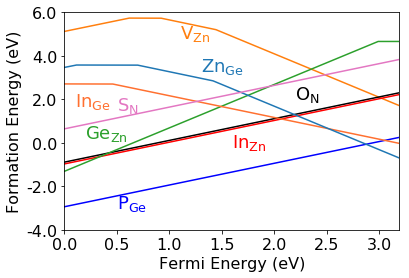

In [3]:
PlotForm({'S_N':[0.5,1.5],'P_Ge':[0.5,-3],'In_Zn':[1.6,-0.2], 'In_Ge':[0.1,1.7], 
          'Zn_Ge':[1.3,3.3],'Ge_Zn':[0.2,0.2], 
          'V_Zn':[1.1,4.8],'O_N':[2.2,2.0]},Gepoor,ylimits=[-4,6])

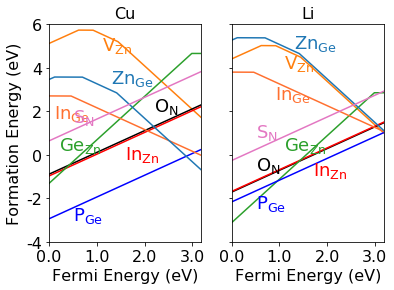

In [4]:
PlotForm2({'S_N':[0.5,1.5],'P_Ge':[0.5,-3],'In_Zn':[1.6,-0.2], 'In_Ge':[0.1,1.7], 
          'Zn_Ge':[1.3,3.3],'Ge_Zn':[0.2,0.2], 
          'V_Zn':[1.1,4.8],'O_N':[2.2,2.0]},Gepoor,{'S_N':[0.5,0.8],'P_Ge':[],'In_Zn':[1.7,-0.93], 'In_Ge':[], 
          'Zn_Ge':[1.3,4.9],'Ge_Zn':[1.1,0.2], 
          'V_Zn':[1.1,4],'O_N':[0.5,-0.7]},Znpoor1,ylimits=[-4,6])

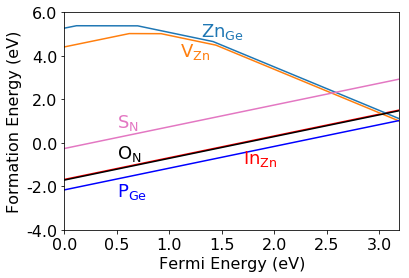

In [5]:
PlotForm({'S_N':[0.5,0.7],'P_Ge':[],'In_Zn':[1.7,-0.93], 
          'Zn_Ge':[1.3,4.9],
          'V_Zn':[1.1,4],'O_N':[0.5,-0.7]},Znpoor1,ylimits=[-4,6])

plt.savefig('ntype.eps', bbox_inches='tight', format='eps', dpi=300)


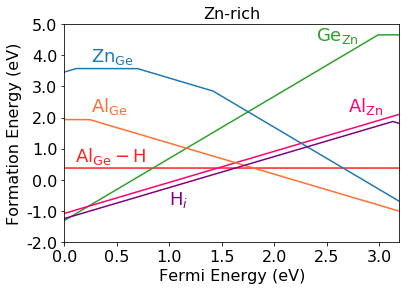

In [6]:
PlotForm({'Al_Ge':[0.25,2.2], 'Al_Ge-H':[0.1,0.6], 'Al_Zn':[2.7,2.2], 
          'Zn_Ge':[0.25,3.8],'Ge_Zn':[2.4,4.5], 'H_i':[1.0,-0.8]},Gepoor,ylimits=[-2,5])

plt.title('Zn-rich', fontsize=16)
plt.savefig('Al_Znrich.png', bbox_inches='tight', format='png', dpi=300)


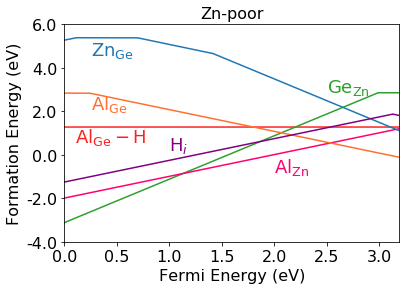

In [7]:
PlotForm({'Al_Ge':[0.25,2.1], 'Al_Ge-H':[0.1,0.6], 'Al_Zn':[2,-0.8], 
          'Zn_Ge':[0.25,4.6],'Ge_Zn':[2.5,2.9], 'H_i':[1.0,0.2]},Znpoor1,ylimits=[-4,6])

plt.title('Zn-poor', fontsize=16)
plt.savefig('Al_Znpoor.png', bbox_inches='tight', format='png', dpi=300)


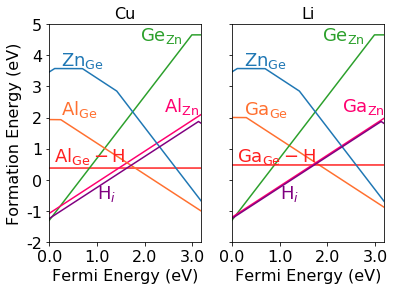

In [8]:
PlotForm2({'Al_Ge':[0.25,2.1], 'Al_Ge-H':[0.1,0.6], 'Al_Zn':[2.4,2.2], 
          'Zn_Ge':[0.25,3.7],'Ge_Zn':[1.9,4.5], 'H_i':[1.0,-0.6]},Gepoor,
          {'Ga_Ge':[0.25,2.1], 'Ga_Ge-H':[0.1,0.6], 'Ga_Zn':[2.3,2.2], 
          'Zn_Ge':[0.25,3.7],'Ge_Zn':[1.9,4.5], 'H_i':[1.0,-0.6]},Gepoor,ylimits=[-2,5])

plt.savefig('Al.png', bbox_inches='tight', format='png', dpi=300)
plt.savefig('Al.eps', bbox_inches='tight', format='eps', dpi=300)


In [9]:
def PlotForm3(Defects1, Condition1, Defects2, Condition2, Defects3, Condition3, BandEdges=bEdges,ylimits=[]):
    fig = plt.figure(figsize=(6,4)) 
    ax = plt.subplot(131)
    Ef = np.arange(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'],0.0001)
    textx = 0.5
    for i in Defects1:
        if not i in colors:
            colour = 'black'
        else:
            colour = colors[i]
        y = getLine(i, Condition1, BandEdges, Ef)
        plt.plot(Ef, y, label=i, color=colour)
        if Defects1[i]:
            ax.text(Defects1[i][0],Defects1[i][1],text_def[i],fontdict={'size':18},color=colour)
        elif i in text_def:
            ax.text(textx,y[int(textx/max(Ef)*len(Ef))]-0.8,text_def[i],fontdict={'size':18},color=colour)
            textx += 0.4
    plt.xlim(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'])
    if ylimits:
        plt.ylim(ylimits[0],ylimits[1])
    plt.ylabel('Formation Energy (eV)', fontsize=16)
    ax.set_xticks([0, 1, 2, 3])
    ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=16)
    ax.set_xticklabels(ax.get_xticks().astype(int), fontsize=16)
    plt.title('Al', fontsize=16)
    ax.arrow(2.2, -1.4, 0, 1.8, head_width=0.2, head_length=0.4, length_includes_head=True,fc=colors['Al_Ge-H'], ec=colors['Al_Ge-H'])

    
    ax = plt.subplot(132)
    Ef = np.arange(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'],0.0001)
    textx = 0.5
    for i in Defects2:
        if not i in colors:
            colour = 'black'
        else:
            colour = colors[i]
        y = getLine(i, Condition2, BandEdges, Ef)
        plt.plot(Ef, y, label=i, color=colour)
        if Defects2[i]:
            ax.text(Defects2[i][0],Defects2[i][1],text_def[i],fontdict={'size':18},color=colour)
        elif i in text_def:
            ax.text(textx,y[int(textx/max(Ef)*len(Ef))]-0.8,text_def[i],fontdict={'size':18},color=colour)
            textx += 0.4
    plt.xlim(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'])
    if ylimits:
        plt.ylim(ylimits[0],ylimits[1])
    ax.set_xticks([0, 1, 2, 3])
    ax.set_yticklabels([])
    plt.xlabel('Fermi Energy (eV)', fontsize=16)
    ax.set_xticklabels(ax.get_xticks().astype(int), fontsize=16)
    plt.title('Ga', fontsize=16)
    ax.arrow(2.2, -1.5, 0, 1.95, head_width=0.2, head_length=0.4, length_includes_head=True,fc=colors['Ga_Ge-H'], ec=colors['Ga_Ge-H'])

    
    ax = plt.subplot(133)
    Ef = np.arange(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'],0.0001)
    textx = 0.5
    for i in Defects3:
        if not i in colors:
            colour = 'black'
        else:
            colour = colors[i]
        y = getLine(i, Condition3, BandEdges, Ef)
        plt.plot(Ef, y, label=i, color=colour)
        if Defects3[i]:
            ax.text(Defects3[i][0],Defects3[i][1],text_def[i],fontdict={'size':18},color=colour)
        elif i in text_def:
            ax.text(textx,y[int(textx/max(Ef)*len(Ef))]-0.8,text_def[i],fontdict={'size':18},color=colour)
            textx += 0.4
    plt.xlim(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'])
    if ylimits:
        plt.ylim(ylimits[0],ylimits[1])
    ax.set_xticks([0, 1, 2, 3])
    ax.set_yticklabels([])
    ax.set_xticklabels(ax.get_xticks().astype(int), fontsize=16)
    plt.title('In', fontsize=16)
    plt.tight_layout()


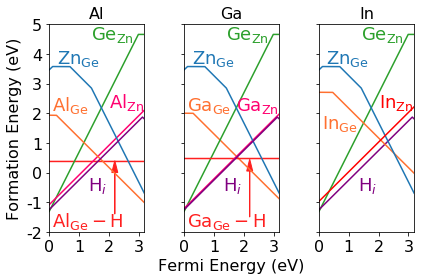

In [10]:
PlotForm3({'Al_Ge':[0.1,2.1], 'Al_Ge-H':[0.1,-1.8], 'Al_Zn':[2.0,2.2], 
          'Zn_Ge':[0.25,3.7],'Ge_Zn':[1.4,4.5], 'H_i':[1.3,-0.6]},Gepoor,
          {'Ga_Ge':[0.1,2.1], 'Ga_Ge-H':[0.1,-1.8], 'Ga_Zn':[1.75,2.1], 
          'Zn_Ge':[0.25,3.7],'Ge_Zn':[1.4,4.5], 'H_i':[1.3,-0.6]},Gepoor,
          {'In_Ge':[0.1,1.5], 'In_Zn':[2.0,2.2], 
          'Zn_Ge':[0.25,3.7],'Ge_Zn':[1.4,4.5], 'H_i':[1.3,-0.6]},Gepoor,ylimits=[-2,5])


plt.savefig('G3.png', bbox_inches='tight', format='png', dpi=300)
plt.savefig('G3.eps', bbox_inches='tight', format='eps', dpi=300)


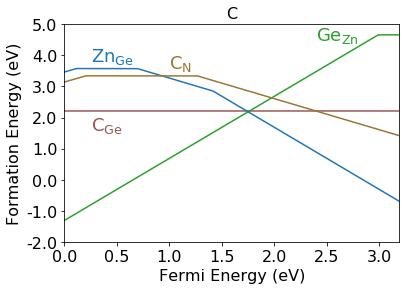

In [11]:
PlotForm({'Zn_Ge':[0.25,3.8],'Ge_Zn':[2.4,4.5], 
          'C_N':[1.0,3.6],'C_Ge':[0.25,1.6]},Gepoor,ylimits=[-2,5])
#'V_Zn-H':[0.3,2.4],
plt.title('C', fontsize=16)
plt.savefig('C.eps', bbox_inches='tight', format='eps', dpi=300)


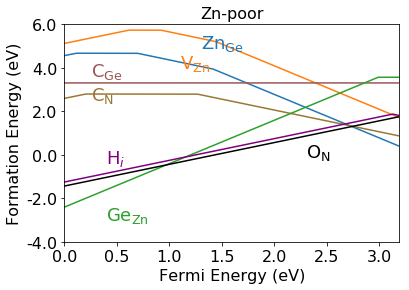

In [12]:
PlotForm({'Zn_Ge':[1.3,4.9],'Ge_Zn':[0.4,-3.0], 
          'V_Zn':[1.1,4], 'C_N':[0.25,2.5],'C_Ge':[0.25,3.6],
          'O_N':[2.3,-0.1], 'H_i':[0.4,-0.4]},Npoor,ylimits=[-4,6])
# 'V_Zn-H':[0.3,1.4]
plt.title('Zn-poor', fontsize=16)
plt.savefig('UnintentionalDefectsZnpoor.png', bbox_inches='tight', format='png', dpi=300)


In [13]:
def PlotForm(Defects, Condition, BandEdges=bEdges,ylimits=[]):
    fig = plt.figure(figsize=(6,4))
    ax = plt.subplot(111)
    Ef = np.arange(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'],0.0001)
    textx = 0.5
    for i in Defects:
        if not i in colors:
            colour = 'black'
        else:
            colour = colors[i]
        y = getLine(i, Condition, BandEdges, Ef)
        plt.plot(Ef, y, label=i, color=colour)
        if Defects[i]:
            ax.text(Defects[i][0],Defects[i][1],text_def[i],fontdict={'size':18},color=colour)
        elif i in text_def:
            ax.text(textx,y[int(textx/max(Ef)*len(Ef))]-0.8,text_def[i],fontdict={'size':18},color=colour)
            textx += 0.4
    plt.xlim(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'])
    if ylimits:
        plt.ylim(ylimits[0],ylimits[1])
    plt.ylabel('Formation Energy (eV)', fontsize=16)
    ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=16)
    plt.xlabel('Fermi Energy (eV)', fontsize=16)
    ax.set_xticklabels(ax.get_xticks(), fontsize=16)

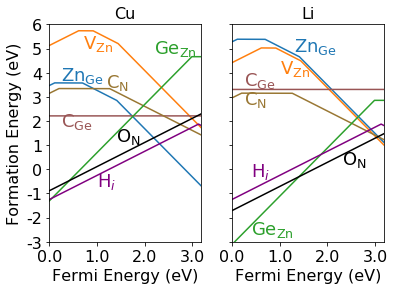

In [14]:
PlotForm2({'Zn_Ge':[0.25,3.7],'Ge_Zn':[2.2,4.8], 
          'V_Zn':[0.7,5], 'C_N':[1.2,3.4],'C_Ge':[0.25,1.8],
          'O_N':[1.4,1.15], 'H_i':[1.0,-0.7]},Gepoor,
         {'Zn_Ge':[1.3,4.9],'Ge_Zn':[0.4,-2.7], 
          'V_Zn':[1.0,4], 'C_N':[0.25,2.7],'C_Ge':[0.25,3.5],
          'O_N':[2.3,0.2], 'H_i':[0.4,-0.3]},Znpoor1,ylimits=[-3,6])

plt.savefig('C.png', bbox_inches='tight', format='png', dpi=300)
plt.savefig('C.eps', bbox_inches='tight', format='eps', dpi=300)



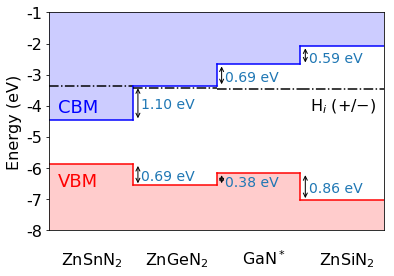

In [15]:
fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
ax.set_xlim([0,2.0])
ax.set_ylim([0,7])
ax.set_xticks([]) 
ax.set_yticklabels(list(np.arange(8)-8), fontsize=16) 
plt.ylabel('Energy (eV)', fontsize=16)


Si_VB = bEdges['ZnSiN2_VB']
Si_CB = bEdges['ZnSiN2_CB']
Si_H = 3.573
Si_Surf = SurfaceCalc['ZnSiN2_100_PBErelax']

Ge_VB = bEdges['ZnGeN2_VB']
Ge_CB = bEdges['ZnGeN2_CB']
Ge_H = 3.1263
Ge_Surf = SurfaceCalc['ZnGeN2_100_PBErelax']


Sn_VB = bEdges['ZnSnN2_VB']
Sn_CB = bEdges['ZnSnN2_CB']
Sn_H = 2.5190
Sn_Surf = SurfaceCalc['ZnSnN2_100_PBErelax']

V = 8.0

C1 = 'red'
C2 = 'blue'
plt.plot([0,0.5],[V - Sn_Surf + Sn_VB, V - Sn_Surf + Sn_VB],C1)
plt.plot([0,0.5],[V - Sn_Surf + Sn_CB, V - Sn_Surf + Sn_CB],C2)
plt.plot([0.0,0.5],[V - Sn_Surf + Sn_VB + Sn_H,V - Sn_Surf + Sn_VB + Sn_H],'black', linestyle='-.') 

plt.plot([0.5,0.5],[V - Sn_Surf + Sn_VB,V - Ge_Surf + Ge_VB],C1)
plt.plot([0.5,0.5],[V - Sn_Surf + Sn_CB,V - Ge_Surf + Ge_CB],C2)

plt.plot([0.5,1.0],[V - Ge_Surf + Ge_VB, V - Ge_Surf + Ge_VB],C1)
plt.plot([0.5,1.0],[V - Ge_Surf + Ge_CB, V - Ge_Surf + Ge_CB],C2)
plt.plot([0.5,1.0],[V - Ge_Surf + Ge_VB + Ge_H,V - Ge_Surf + Ge_VB + Ge_H],'black', linestyle='-.') 

Ga_temp = (V - Si_Surf + Si_VB + Si_H)/2.0 + (V - Ge_Surf + Ge_VB + Ge_H)/2.0
Ga_temp_VB = Ga_temp - 2.72
Ga_temp_CB = Ga_temp - 2.72 + 3.5

plt.plot([1.0,1.0],[V - Ge_Surf + Ge_VB, Ga_temp_VB],C1)
plt.plot([1.0,1.0],[V - Ge_Surf + Ge_CB, Ga_temp_CB],C2)

plt.plot([1.0,1.5],[Ga_temp_VB, Ga_temp_VB],C1)
plt.plot([1.0,1.5],[Ga_temp_CB, Ga_temp_CB],C2)
plt.plot([1.0,1.5],[Ga_temp,  Ga_temp],'black', linestyle='-.') 


plt.plot([1.5,1.5],[Ga_temp_VB, V - Si_Surf + Si_VB],C1)
plt.plot([1.5,1.5],[Ga_temp_CB, V - Si_Surf + Si_CB],C2)


plt.plot([1.5,2],[V - Si_Surf + Si_VB, V - Si_Surf + Si_VB],C1)
plt.plot([1.5,2],[V - Si_Surf + Si_CB, V - Si_Surf + Si_CB],C2)
plt.plot([1.5,2],[V - Si_Surf + Si_VB + Si_H,V - Si_Surf + Si_VB + Si_H],'black', linestyle='-.') 

ax.text(0.07, -1.1,u'ZnSnN$_{2}$',fontdict={'size':16},color='black')
ax.text(0.57, -1.1,u'ZnGeN$_{2}$',fontdict={'size':16},color='black')
ax.text(1.15, -1.1,r'GaN$^*$',fontdict={'size':16},color='black')
ax.text(1.61, -1.1,u'ZnSiN$_{2}$',fontdict={'size':16},color='black')

ax.text(1.56,Ga_temp-0.7,r'H$_i$ (+/$-$)',fontdict={'size':16},color='black')
ax.text(0.05, 1.4 ,u'VBM',fontdict={'size':18},color='red')
ax.text(0.05, 3.8 ,u'CBM',fontdict={'size':18},color='blue')




plt.annotate(s='', xy=(0.53,V - Sn_Surf + Sn_CB), xytext=(0.53,V - Ge_Surf + Ge_CB), arrowprops=dict(arrowstyle='<->'))
ax.text(0.55, 3.9, "1.10 eV",fontdict={'size':14},color='C0')


plt.annotate(s='', xy=(1.03,V - Ge_Surf + Ge_CB), xytext=(1.03,Ga_temp_CB), arrowprops=dict(arrowstyle='<->'))
ax.text(1.05, 4.8, "0.69 eV",fontdict={'size':14},color='C0')

plt.annotate(s='', xy=(1.53,Ga_temp_CB), xytext=(1.53,V - Si_Surf + Si_CB), arrowprops=dict(arrowstyle='<->'))
ax.text(1.55, 5.4, "0.59 eV",fontdict={'size':14},color='C0')




plt.annotate(s='', xy=(0.53,V - Sn_Surf + Sn_VB), xytext=(0.53,V - Ge_Surf + Ge_VB), arrowprops=dict(arrowstyle='<->'))
ax.text(0.55, 1.6, "0.69 eV",fontdict={'size':14},color='C0')


plt.annotate(s='', xy=(1.03,V - Ge_Surf + Ge_VB), xytext=(1.03,Ga_temp_VB), arrowprops=dict(arrowstyle='<->'))
ax.text(1.05, 1.4, "0.38 eV",fontdict={'size':14},color='C0')


plt.annotate(s='', xy=(1.53,Ga_temp_VB), xytext=(1.53,V - Si_Surf + Si_VB), arrowprops=dict(arrowstyle='<->'))
ax.text(1.55, 1.2, "0.86 eV",fontdict={'size':14},color='C0')


ax.fill_between([0,0.5],0,V - Sn_Surf + Sn_VB,facecolor='#ffcccc')
ax.fill_between([0.5,1.0],0,V - Ge_Surf + Ge_VB,facecolor='#ffcccc')
ax.fill_between([1,1.5],0,Ga_temp_VB,facecolor='#ffcccc')
ax.fill_between([1.5,2.0],0,V - Si_Surf + Si_VB,facecolor='#ffcccc')

ax.fill_between([0,0.5],V - Sn_Surf + Sn_CB,7,facecolor='#ccccff')
ax.fill_between([0.5,1.0],V - Ge_Surf + Ge_CB,7,facecolor='#ccccff')
ax.fill_between([1,1.5],Ga_temp_CB,7,facecolor='#ccccff')
ax.fill_between([1.5,2.0],V - Si_Surf + Si_CB,7,facecolor='#ccccff')



plt.savefig('ZnGeN2GaNoffset.eps', bbox_inches='tight', format='eps', dpi=300)
plt.savefig('ZnGeN2GaNoffset.png', bbox_inches='tight', format='png', dpi=300)
plt.show()

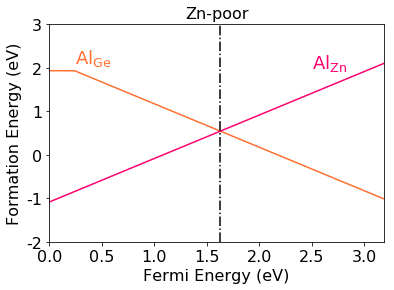

In [16]:
PlotForm({'Al_Ge':[0.25,2.1], 'Al_Zn':[2.5,2]},Gepoor,ylimits=[-2,3])
plt.plot([1.63, 1.63],[-2,3],'-.', color='black')



plt.title('Zn-poor', fontsize=16)
plt.savefig('Al_compAPS.png', bbox_inches='tight', format='png', dpi=300)


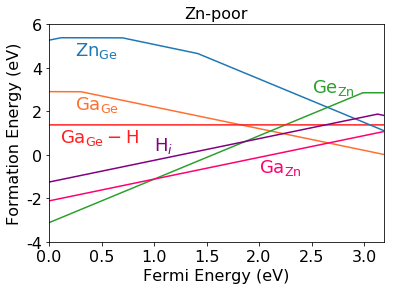

In [17]:
PlotForm({'Ga_Ge':[0.25,2.1], 'Ga_Ge-H':[0.1,0.6], 'Ga_Zn':[2,-0.8], 
          'Zn_Ge':[0.25,4.6],'Ge_Zn':[2.5,2.9], 'H_i':[1.0,0.2]},Znpoor1,ylimits=[-4,6])

plt.title('Zn-poor', fontsize=16)
plt.savefig('Ga_Znpoor.png', bbox_inches='tight', format='png', dpi=300)


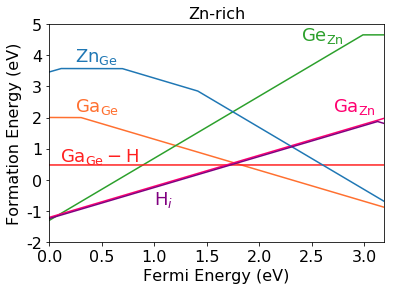

In [18]:
PlotForm({'Ga_Ge':[0.25,2.2], 'Ga_Ge-H':[0.1,0.6], 'Ga_Zn':[2.7,2.2], 
          'Zn_Ge':[0.25,3.8],'Ge_Zn':[2.4,4.5], 'H_i':[1.0,-0.8]},Gepoor,ylimits=[-2,5])

plt.title('Zn-rich', fontsize=16)
plt.savefig('Ga_Znrich.png', bbox_inches='tight', format='png', dpi=300)


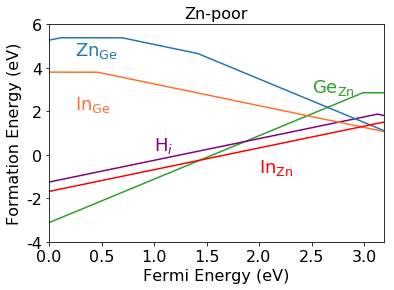

In [19]:
PlotForm({'In_Ge':[0.25,2.1], 'In_Zn':[2,-0.8], 
          'Zn_Ge':[0.25,4.6],'Ge_Zn':[2.5,2.9], 'H_i':[1.0,0.2]},Znpoor1,ylimits=[-4,6])

plt.title('Zn-poor', fontsize=16)
plt.savefig('In_Znpoor.png', bbox_inches='tight', format='png', dpi=300)


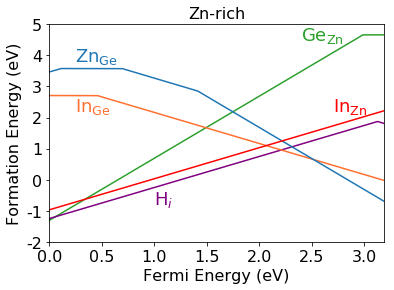

In [20]:
PlotForm({'In_Ge':[0.25,2.2], 'In_Zn':[2.7,2.2], 
          'Zn_Ge':[0.25,3.8],'Ge_Zn':[2.4,4.5], 'H_i':[1.0,-0.8]},Gepoor,ylimits=[-2,5])

plt.title('Zn-rich', fontsize=16)
plt.savefig('In_Znrich.png', bbox_inches='tight', format='png', dpi=300)


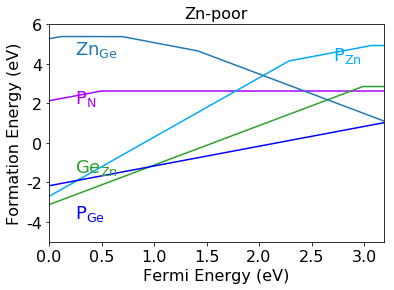

In [21]:
PlotForm({'P_Ge':[0.25,-3.8], 'P_Zn':[2.7,4.2], 'P_N':[0.25,2.0],
          'Zn_Ge':[0.25,4.5],'Ge_Zn':[0.25,-1.5]},Znpoor1,ylimits=[-5,6])

plt.title('Zn-poor', fontsize=16)
plt.savefig('P_Znpoor.png', bbox_inches='tight', format='png', dpi=300)


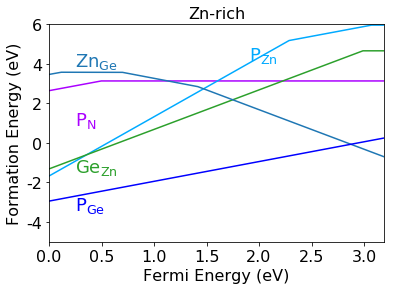

In [22]:
PlotForm({'P_Ge':[0.25,-3.4], 'P_Zn':[1.9,4.2], 'P_N':[0.25,0.9],
          'Zn_Ge':[0.25,3.9],'Ge_Zn':[0.25,-1.5]},Gepoor,ylimits=[-5,6])

plt.title('Zn-rich', fontsize=16)
plt.savefig('P_Znrich.png', bbox_inches='tight', format='png', dpi=300)


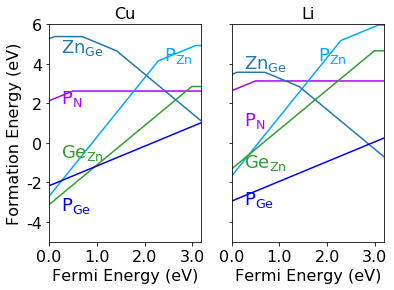

In [23]:
PlotForm2({'P_Ge':[0.25,-3.4], 'P_Zn':[2.4,4.2], 'P_N':[0.25,2.0],
          'Zn_Ge':[0.25,4.6],'Ge_Zn':[0.25,-0.7]},Znpoor1,
         {'P_Ge':[0.25,-3.1], 'P_Zn':[1.8,4.2], 'P_N':[0.25,0.9],
          'Zn_Ge':[0.25,3.8],'Ge_Zn':[0.25,-1.2]},Gepoor,ylimits=[-5,6])

plt.savefig('P.png', bbox_inches='tight', format='png', dpi=300)
plt.savefig('P.eps', bbox_inches='tight', format='eps', dpi=300)


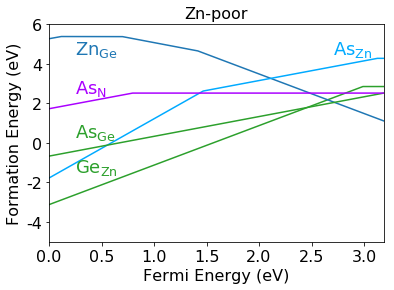

In [24]:
PlotForm({'As_Ge':[0.25,0.3], 'As_Zn':[2.7,4.5], 'As_N':[0.25,2.5],
          'Zn_Ge':[0.25,4.5],'Ge_Zn':[0.25,-1.5]},Znpoor1,ylimits=[-5,6])

plt.title('Zn-poor', fontsize=16)
plt.savefig('As_Znpoor.png', bbox_inches='tight', format='png', dpi=300)


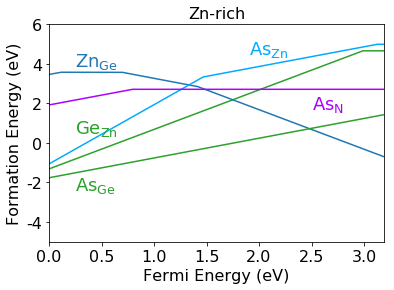

In [25]:
PlotForm({'As_Ge':[0.25,-2.4], 'As_Zn':[1.9,4.5], 'As_N':[2.5,1.7],
          'Zn_Ge':[0.25,3.9],'Ge_Zn':[0.25,0.5]},Gepoor,ylimits=[-5,6])

plt.title('Zn-rich', fontsize=16)
plt.savefig('As_Znrich.png', bbox_inches='tight', format='png', dpi=300)


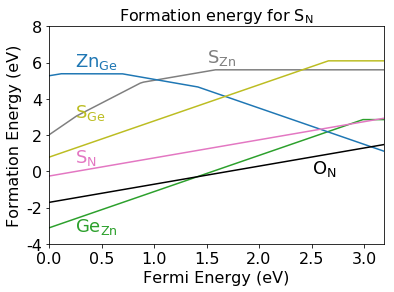

In [26]:
PlotForm({'S_Ge':[0.25,3], 'S_Zn':[1.5,6.0], 'S_N':[0.25,0.5], 'O_N':[2.5,-0.1],
          'Zn_Ge':[0.25,5.8],'Ge_Zn':[0.25,-3.3]},Znpoor1,ylimits=[-4,8])

plt.title(r'Formation energy for S$\rm_N$', fontsize=16)
plt.savefig('S_Znpoor.png', bbox_inches='tight', format='png', dpi=300)


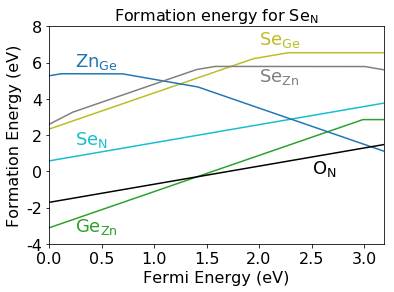

In [27]:
PlotForm({'Se_Ge':[2.0,7.0], 'Se_Zn':[2.0,5.0], 'Se_N':[0.25,1.5], 'O_N':[2.5,-0.1],
          'Zn_Ge':[0.25,5.8],'Ge_Zn':[0.25,-3.3]},Znpoor1,ylimits=[-4,8])

plt.title(r'Formation energy for Se$\rm_N$', fontsize=16)
plt.savefig('Se_Znpoor.png', bbox_inches='tight', format='png', dpi=300)


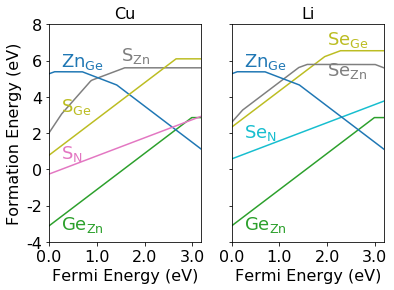

In [28]:
PlotForm2({'S_Ge':[0.25,3.2], 'S_Zn':[1.5,6.0], 'S_N':[0.25,0.6],
          'Zn_Ge':[0.25,5.7],'Ge_Zn':[0.25,-3.3]},Znpoor1,
         {'Se_Ge':[2.0,6.9], 'Se_Zn':[2.0,5.2], 'Se_N':[0.25,1.8], 
          'Zn_Ge':[0.25,5.7],'Ge_Zn':[0.25,-3.3]},Znpoor1,ylimits=[-4,8])

plt.savefig('SSe.eps', bbox_inches='tight', format='eps', dpi=300)


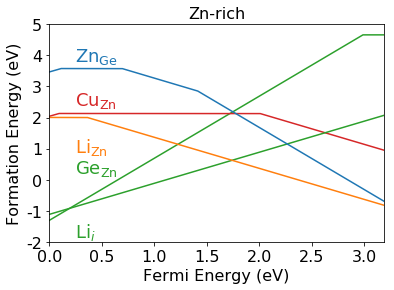

In [29]:
PlotForm({'Li_i':[0.25,-1.85], 'Li_Zn':[0.25,0.9], 'Cu_Zn':[0.25,2.4], 
          'Zn_Ge':[0.25,3.8],'Ge_Zn':[0.25,0.2]},Gepoor,ylimits=[-2,5])

plt.title('Zn-rich', fontsize=16)
plt.savefig('Li.eps', bbox_inches='tight', format='eps', dpi=300)


In [30]:
def PlotForm2(Defects1, Condition1, Defects2, Condition2, BandEdges=bEdges,ylimits=[]):
    fig = plt.figure(figsize=(6,4)) 
    ax = plt.subplot(121)
    Ef = np.arange(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'],0.0001)
    textx = 0.5
    for i in Defects1:
        if not i in colors:
            colour = 'black'
        else:
            colour = colors[i]
        y = getLine(i, Condition1, BandEdges, Ef)
        plt.plot(Ef, y, label=i, color=colour)
        if Defects1[i]:
            ax.text(Defects1[i][0],Defects1[i][1],text_def[i],fontdict={'size':18},color=colour)
        elif i in text_def:
            ax.text(textx,y[int(textx/max(Ef)*len(Ef))]-0.8,text_def[i],fontdict={'size':18},color=colour)
            textx += 0.4
    plt.xlim(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'])
    if ylimits:
        plt.ylim(ylimits[0],ylimits[1])
    plt.ylabel('Formation Energy (eV)', fontsize=16)
    ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=16)
    ax.set_xticklabels(ax.get_xticks(), fontsize=16)
    plt.title('Cu', fontsize=16)

    
    ax = plt.subplot(122)
    Ef = np.arange(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'],0.0001)
    textx = 0.5
    for i in Defects2:
        if not i in colors:
            colour = 'black'
        else:
            colour = colors[i]
        y = getLine(i, Condition2, BandEdges, Ef)
        plt.plot(Ef, y, label=i, color=colour)
        if Defects2[i]:
            ax.text(Defects2[i][0],Defects2[i][1],text_def[i],fontdict={'size':18},color=colour)
        elif i in text_def:
            ax.text(textx,y[int(textx/max(Ef)*len(Ef))]-0.8,text_def[i],fontdict={'size':18},color=colour)
            textx += 0.4
    plt.xlim(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'])
    if ylimits:
        plt.ylim(ylimits[0],ylimits[1])
    ax.set_yticklabels([], fontsize=16)
    ax.set_xticklabels(ax.get_xticks(), fontsize=16)
    plt.title('Li', fontsize=16)
    fig.text(0.5, -0.02, 'Fermi Energy (eV)', ha='center', fontsize=16)



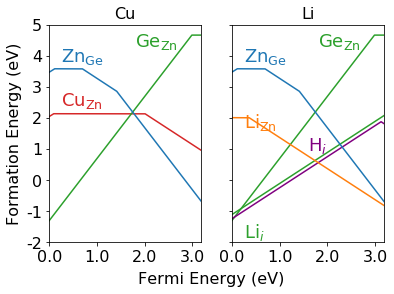

In [31]:
PlotForm2({'Cu_Zn':[0.25,2.4], 'Zn_Ge':[0.25,3.8],'Ge_Zn':[1.8,4.3]},Gepoor,
          {'Li_i':[0.25,-1.85], 'Li_Zn':[0.25,1.7], 'H_i':[1.6,0.95], 
          'Zn_Ge':[0.25,3.8],'Ge_Zn':[1.8,4.3]},Gepoor,ylimits=[-2,5])

plt.savefig('G1.eps', bbox_inches='tight', format='eps', dpi=300)


In [32]:
def PlotForm4(Defects1, Condition1, Defects2, Condition2,Defects3, Condition3,Defects4, Condition4, BandEdges=bEdges,ylimits=[]):
    fig = plt.figure(figsize=(6,6)) 
    ax = plt.subplot(221)
    Ef = np.arange(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'],0.0001)
    textx = 0.5
    for i in Defects1:
        if not i in colors:
            colour = 'black'
        else:
            colour = colors[i]
        y = getLine(i, Condition1, BandEdges, Ef)
        plt.plot(Ef, y, label=i, color=colour)
        if Defects1[i]:
            ax.text(Defects1[i][0],Defects1[i][1],text_def[i],fontdict={'size':18},color=colour)
        elif i in text_def:
            ax.text(textx,y[int(textx/max(Ef)*len(Ef))]-0.8,text_def[i],fontdict={'size':18},color=colour)
            textx += 0.4
    plt.xlim(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'])
    if ylimits:
        plt.ylim(ylimits[0],ylimits[1])
    plt.ylabel('Formation Energy (eV)', fontsize=16)
    ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=16)
    ax.set_xticklabels([], fontsize=16)
    plt.title('S', fontsize=16)

    
    ax = plt.subplot(222)
    Ef = np.arange(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'],0.0001)
    textx = 0.5
    for i in Defects2:
        if not i in colors:
            colour = 'black'
        else:
            colour = colors[i]
        y = getLine(i, Condition2, BandEdges, Ef)
        plt.plot(Ef, y, label=i, color=colour)
        if Defects2[i]:
            ax.text(Defects2[i][0],Defects2[i][1],text_def[i],fontdict={'size':18},color=colour)
        elif i in text_def:
            ax.text(textx,y[int(textx/max(Ef)*len(Ef))]-0.8,text_def[i],fontdict={'size':18},color=colour)
            textx += 0.4
    plt.xlim(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'])
    if ylimits:
        plt.ylim(ylimits[0],ylimits[1])
    ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=16)
    ax.set_xticklabels([], fontsize=16)
    plt.title('Se', fontsize=16)
    
    ax = plt.subplot(223)
    Ef = np.arange(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'],0.0001)
    textx = 0.5
    for i in Defects3:
        if not i in colors:
            colour = 'black'
        else:
            colour = colors[i]
        y = getLine(i, Condition3, BandEdges, Ef)
        plt.plot(Ef, y, label=i, color=colour)
        if Defects3[i]:
            ax.text(Defects3[i][0],Defects3[i][1],text_def[i],fontdict={'size':18},color=colour)
        elif i in text_def:
            ax.text(textx,y[int(textx/max(Ef)*len(Ef))]-0.8,text_def[i],fontdict={'size':18},color=colour)
            textx += 0.4
    plt.xlim(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'])
    if ylimits:
        plt.ylim(ylimits[2],ylimits[3])
    plt.ylabel('Formation Energy (eV)', fontsize=16)
    ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=16)
    plt.xlabel('Fermi Energy (eV)', fontsize=16)
    ax.set_xticklabels(ax.get_xticks(), fontsize=16)
    plt.title('P', fontsize=16)

    
    ax = plt.subplot(224)
    Ef = np.arange(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'],0.0001)
    textx = 0.5
    for i in Defects4:
        if not i in colors:
            colour = 'black'
        else:
            colour = colors[i]
        y = getLine(i, Condition4, BandEdges, Ef)
        plt.plot(Ef, y, label=i, color=colour)
        if Defects4[i]:
            ax.text(Defects4[i][0],Defects4[i][1],text_def[i],fontdict={'size':18},color=colour)
        elif i in text_def:
            ax.text(textx,y[int(textx/max(Ef)*len(Ef))]-0.8,text_def[i],fontdict={'size':18},color=colour)
            textx += 0.4
    plt.xlim(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'])
    if ylimits:
        plt.ylim(ylimits[2],ylimits[3])
    ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=16)
    plt.xlabel('Fermi Energy (eV)', fontsize=16)
    ax.set_xticklabels(ax.get_xticks(), fontsize=16)
    plt.title('As', fontsize=16)
    plt.tight_layout()

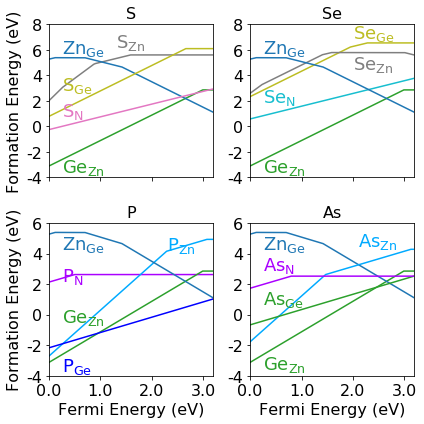

In [33]:
PlotForm4({'S_Ge':[0.25,2.8], 'S_Zn':[1.3,6.2], 'S_N':[0.25,0.8],
          'Zn_Ge':[0.25,5.7],'Ge_Zn':[0.25,-3.6]},Znpoor1,
         {'Se_Ge':[2.0,6.9], 'Se_Zn':[2.0,4.5], 'Se_N':[0.25,1.9], 
          'Zn_Ge':[0.25,5.7],'Ge_Zn':[0.25,-3.6]},Znpoor1,
          {'P_Ge':[0.25,-3.7], 'P_Zn':[2.3,4.2], 'P_N':[0.25,2.2],
          'Zn_Ge':[0.25,4.3],'Ge_Zn':[0.25,-0.5]},Znpoor1,
          {'As_Ge':[0.25,0.7], 'As_Zn':[2.1,4.5], 'As_N':[0.25,2.9],
          'Zn_Ge':[0.25,4.3],'Ge_Zn':[0.25,-3.6]},Znpoor1,ylimits=[-4,8,-4,6])

plt.savefig('PAsSSe.eps', bbox_inches='tight', format='eps', dpi=300)


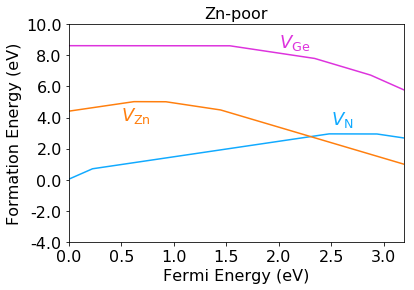

In [45]:
PlotForm({'V_Zn':[0.5,3.8], 'V_Ge':[2.0,8.5], 'V_N':[2.5,3.6]},Znpoor1,ylimits=[-4,10])

plt.title('Zn-poor', fontsize=16)
plt.savefig('Vac.png', bbox_inches='tight', format='png', dpi=300)


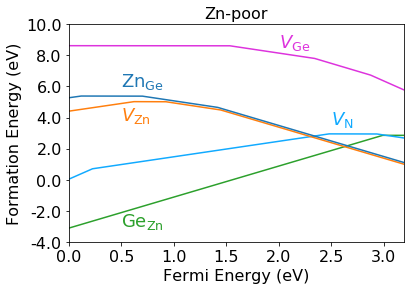

In [46]:
PlotForm({'V_Zn':[0.5,3.8], 'V_Ge':[2.0,8.5], 'V_N':[2.5,3.6],
          'Zn_Ge':[0.5,6.0],'Ge_Zn':[0.5,-3.0]},Znpoor1,ylimits=[-4,10])

plt.title('Zn-poor', fontsize=16)
plt.savefig('VacAnti.png', bbox_inches='tight', format='png', dpi=300)


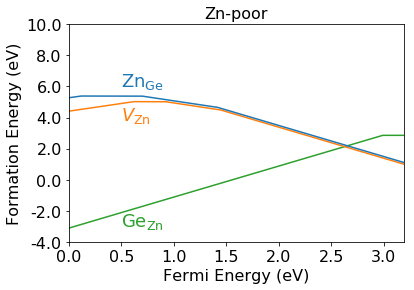

In [47]:
PlotForm({'V_Zn':[0.5,3.8], 
          'Zn_Ge':[0.5,6.0],'Ge_Zn':[0.5,-3.0]},Znpoor1,ylimits=[-4,10])

plt.title('Zn-poor', fontsize=16)
plt.savefig('VacAnti3.png', bbox_inches='tight', format='png', dpi=300)


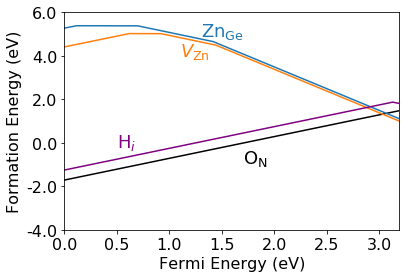

In [48]:
PlotForm({'H_i':[0.5,-0.2], 
          'Zn_Ge':[1.3,4.9],
          'V_Zn':[1.1,4],'O_N':[1.7,-0.93]},Znpoor1,ylimits=[-4,6])

plt.savefig('ntype.png', bbox_inches='tight', format='png', dpi=300)
